## 경기 지표 데이터 설명

| **변수명**      | **설명**                                              |
|------------------|-------------------------------------------------------|
| **GP**           | Games Played: 경기 출전 횟수                          |
| **W**            | Wins: 팀의 승리 수                                     |
| **L**            | Losses: 팀의 패배 수                                   |
| **Min**          | Minutes Played: 총 출전 시간(분)                       |
| **PTS**          | Points: 총 득점                                        |
| **FGM**          | Field Goals Made: 성공한 필드골 수                     |
| **FGA**          | Field Goals Attempted: 시도한 필드골 수                |
| **FG%**          | Field Goal Percentage: 필드골 성공률                  |
| **3PM**          | 3 Point Field Goals Made: 성공한 3점슛 수              |
| **3PA**          | 3 Point Field Goals Attempted: 시도한 3점슛 수         |
| **3P%**          | 3 Point Field Goal Percentage: 3점슛 성공률           |
| **FTM**          | Free Throws Made: 성공한 자유투 수                     |
| **FTA**          | Free Throws Attempted: 시도한 자유투 수                |
| **FT%**          | Free Throw Percentage: 자유투 성공률                  |
| **OREB**         | Offensive Rebounds: 공격 리바운드 수                   |
| **DREB**         | Defensive Rebounds: 수비 리바운드 수                   |
| **REB**          | Rebounds: 총 리바운드 수 (OREB + DREB)                |
| **AST**          | Assists: 어시스트 수                                   |
| **TOV**          | Turnovers: 실책 수                                     |
| **STL**          | Steals: 스틸 수                                        |
| **BLK**          | Blocks: 블록 수                                        |
| **PF**           | Personal Fouls: 개인 반칙 수                           |
| **FP**           | Fantasy Points: 판타지 리그 포인트                     |
| **DD2**          | Double Doubles: 10 이상 기록한 스탯이 두 개 이상인 경기 |
| **TD3**          | Triple Doubles: 10 이상 기록한 스탯이 세 개 이상인 경기 |
| **+/-**          | Plus-Minus: 선수가 코트에 있을 때 팀의 득실차          |


### 한글 폰트 설정

In [537]:
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

### 데이터 전처리에 필요한 변수 선언 및 초기화

In [538]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import unicodedata
import seaborn as sns

# 폴더 경로 지정하기
stats_data_path = "./stats_data/"
salary_data_path = "./salary_data/"

# 해당 폴더 안에 있는 파일 리스트 불러오기
stats_files = os.listdir(stats_data_path)
salary_files = os.listdir(salary_data_path)

# 오름 차순으로 파일 명 정렬
stats_files = sorted(stats_files, reverse=False)
salary_files = sorted(salary_files, reverse=False)

# 연봉 비율 계산을 위한 시즌별 샐러리 캡
salary_cap = {
    2012: 58044000,
    2013: 58679000,
    2014: 63065000,
    2015: 70000000,
    2016: 94143000,
    2017: 99093000,
    2018: 101869000,
    2019: 109140000,
    2020: 109140000,
    2021: 112414000,
    2022: 123655000,
    2023: 134000000,
    2024: 143000000,
}
base_salary_cap = salary_cap[2024]

all_data = []  # 데이터 병합을 위한 리스트
salary_year = int(salary_files[0][11:15])  # 연봉 데이터 년도

### 악센트 제거 함수 선언
- 선수 이름에 들어가는 악센트 제거

In [539]:
# 악센트 제거 함수
def remove_accents(input_str):
    return ''.join(
        char for char in unicodedata.normalize('NFD', input_str)
        if unicodedata.category(char) != 'Mn'  # Nonspacing Mark 제외
    )

### 데이터 전처리 및 결합
- 데이터 전처리
  - 개인 지표 데이터의 이름에는 기본 영어, 연봉 데이터의 선수 이름에는 악센트 표기가 되어 있기 때문에 악센트 제거
  - 연봉 데이터의 숫자 표기가 `,` `$`의 문자가 포함되어 있기 때문에 제거
  - 연봉은 과거와 현재의 경제적 차이 때문에 오차가 발생
  - 과거 연봉 데이터들을 가장 최근 시즌인 2024시즌 샐러리 캡을 이용해서 조정
  
- 데이터 결합 예시
  - 17-18 연봉 데이터는 전년도 개인 지표와 결합 (17-18 연봉 + 16-17 개인 지표)

In [540]:
# 파일들을 시즌별로 처리
for i, (stats_file, salary_file) in enumerate(zip(stats_files, salary_files)):
    try:
        # 데이터 로드
        stats_data = pd.read_csv(stats_data_path + stats_file)
        salary_data = pd.read_csv(salary_data_path + salary_file)
 
        # 연봉 데이터의 이름에서 포지션 제거
        salary_data['NAME'] = salary_data['NAME'].str.split(',').str[0].str.strip()

        # 악센트가 포함되어 있는 선수 악센트 제거
        # 연봉 데이터에는 악센트가 이미 제거 되어있어 개인 지표 데이터에만 실행
        stats_data['Player'] = stats_data['Player'].apply(remove_accents)
        
        # 연봉 데이터에서 $ 제거 및 숫자형으로 변환
        salary_data['SALARY'] = salary_data['SALARY'].replace(r'[\$,]', '', regex=True).astype(int)
        
        # 각 선수의 연봉이 시즌별 샐러리 캡에서 차지하는 비율 계산 SALARY_CAP_RATIO
        # SALARY_CAP_RATIO과 현재 년도의 샐러리 캡을 이용해 에상 연봉 계산 CURRENT_SALARY_PROJECTION
        # 'CURRENT_SALARY_PROJECTION'는 선수 연봉의 상대적 가치를 평가하는 데 사용. (종속변수)
        currunt_salary_cap = salary_cap.get(salary_year)
        salary_data['ADJUSTED_SALARY_FOR_CAP'] = (salary_data['SALARY'] / currunt_salary_cap * base_salary_cap).astype(int)
        
        # 이름을 기준으로 병합
        merged_data = pd.merge(
            stats_data, salary_data,
            how='inner',
            left_on=['Player'],
            right_on=['NAME']
        )
        
        # 시즌 정보 추가
        merged_data['SEASON'] = f'{salary_year}-{salary_year+1}'
        
        # 병합된 데이터 추가
        all_data.append(merged_data)

        salary_year += 1 
    except Exception as e:
        print(f"에러 발생 개인 지표 파일 {stats_file}")
        print(f"에러 발생 개인 연봉 파일 {salary_file}")
        print(f"에러 : {e}")

# 모든 시즌 데이터를 하나의 데이터프레임으로 결합
final_data = pd.concat(all_data, ignore_index=True)
final_data.dropna(axis=1, inplace=True)

# 데이터 확인
final_data.info()
final_data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5337 entries, 0 to 5336
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               5337 non-null   int64  
 1   Player                   5337 non-null   object 
 2   Team                     5337 non-null   object 
 3   Age                      5337 non-null   int64  
 4   GP                       5337 non-null   int64  
 5   W                        5337 non-null   int64  
 6   L                        5337 non-null   int64  
 7   Min                      5337 non-null   float64
 8   PTS                      5337 non-null   float64
 9   FGM                      5337 non-null   float64
 10  FGA                      5337 non-null   float64
 11  FG%                      5337 non-null   float64
 12  3PM                      5337 non-null   float64
 13  3PA                      5337 non-null   float64
 14  3P%                     

,Unnamed: 0,Player,Team,Age,GP,W,L,Min,PTS,FGM,...,FP,DD2,TD3,+/-,RK,NAME,TEAM,SALARY,ADJUSTED_SALARY_FOR_CAP,SEASON
0,1,Kevin Durant,OKC,23,66,47,19,38.6,28.0,9.7,...,46.6,18.0,0.0,5.6,11,Kevin Durant,Oklahoma City Thunder,17832626,43933318,2012-2013
1,2,Kobe Bryant,LAL,33,58,36,22,38.5,27.9,9.9,...,42.1,3.0,0.0,2.4,1,Kobe Bryant,Los Angeles Lakers,30453805,75027463,2012-2013
2,3,LeBron James,MIA,27,62,45,17,37.5,27.1,10.0,...,50.6,23.0,0.0,7.6,8,LeBron James,Miami Heat,19067500,46975613,2012-2013
3,4,Kevin Love,MIN,23,55,24,31,39.0,26.0,8.6,...,46.8,48.0,0.0,0.5,28,Kevin Love,Minnesota Timberwolves,13668750,33674992,2012-2013
4,5,Russell Westbrook,OKC,23,66,47,19,35.3,23.6,8.8,...,39.7,7.0,0.0,5.6,20,Russell Westbrook,Oklahoma City Thunder,14693906,36200616,2012-2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5332,550,DaQuan Jeffries,NYK,26,17,11,6,2.7,0.8,0.4,...,1.6,0.0,0.0,-0.6,344,DaQuan Jeffries,Charlotte Hornets,2425204,2425204,2024-2025
5333,551,Charlie Brown Jr.,NYK,27,8,2,6,4.7,0.8,0.3,...,1.6,0.0,0.0,-0.8,349,Charlie Brown Jr.,Charlotte Hornets,2237692,2237692,2024-2025
5334,552,Wendell Moore Jr.,MIN,22,25,18,7,3.0,0.7,0.4,...,2.2,0.0,0.0,-0.2,335,Wendell Moore Jr.,Detroit Pistons,2537040,2537040,2024-2025
5335,559,E.J. Liddell,NOP,23,8,3,5,2.9,0.5,0.1,...,2.7,0.0,0.0,-0.5,376,E.J. Liddell,Chicago Bulls,2120693,2120693,2024-2025


### 불필요한 독립 변수 제거
- `Unnamed: 0`:  알 수 없는 변수
- `W`, `L`:  팀 승리와 패배 (개인 성과보다 팀 의존적인 지표).
- `PF`:  개인 반칙 (연봉과 낮은 연관성).
- `FP`:  판타지 포인트 (중복된 요약 지표).
- `OREB`, `DREB`:  총 리바운드(`REB`)로 통합.
- `FGM`, `FGA`, `3PM`, `3PA`, `FTA`, `FTM`:  슈팅 효율 지표(`FG%`, `3P%`, `FT%`)로 대체.
- `TEAM`, `Team` : 불필요한 팀 데이터 
- `NAME` : 중복된 변수 존재
- `RK` : 불필요한 순위 데이터


In [541]:
final_data.drop(columns=['Unnamed: 0', 'Team', 'W', 'L', 'FGM', 'FGA', 'PF', 'FP', 'OREB', 'DREB', '3PM', '3PA', 'FTA', 'FTM', 'TEAM', 'NAME', 'RK'], axis=1, inplace=True)
final_data

,Player,Age,GP,Min,PTS,FG%,3P%,FT%,REB,AST,TOV,STL,BLK,DD2,TD3,+/-,SALARY,ADJUSTED_SALARY_FOR_CAP,SEASON
0,Kevin Durant,23,66,38.6,28.0,49.6,38.7,86.0,8.0,3.5,3.8,1.3,1.2,18.0,0.0,5.6,17832626,43933318,2012-2013
1,Kobe Bryant,33,58,38.5,27.9,43.0,30.3,84.5,5.4,4.6,3.5,1.2,0.3,3.0,0.0,2.4,30453805,75027463,2012-2013
2,LeBron James,27,62,37.5,27.1,53.1,36.2,77.1,7.9,6.2,3.4,1.9,0.8,23.0,0.0,7.6,19067500,46975613,2012-2013
3,Kevin Love,23,55,39.0,26.0,44.8,37.2,82.4,13.3,2.0,2.3,0.9,0.5,48.0,0.0,0.5,13668750,33674992,2012-2013
4,Russell Westbrook,23,66,35.3,23.6,45.7,31.6,82.3,4.6,5.5,3.6,1.7,0.3,7.0,0.0,5.6,14693906,36200616,2012-2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5332,DaQuan Jeffries,26,17,2.7,0.8,35.3,20.0,0.0,0.3,0.3,0.2,0.0,0.1,0.0,0.0,-0.6,2425204,2425204,2024-2025
5333,Charlie Brown Jr.,27,8,4.7,0.8,20.0,28.6,0.0,0.3,0.0,0.3,0.0,0.3,0.0,0.0,-0.8,2237692,2237692,2024-2025
5334,Wendell Moore Jr.,22,25,3.0,0.7,50.0,0.0,0.0,0.5,0.2,0.2,0.2,0.0,0.0,0.0,-0.2,2537040,2537040,2024-2025
5335,E.J. Liddell,23,8,2.9,0.5,16.7,0.0,100.0,0.6,0.1,0.3,0.3,0.3,0.0,0.0,-0.5,2120693,2120693,2024-2025


### 샐러리 캡 계산 전후 연도별 평균 연봉 비교 시각화     
- 예상 연봉 계산 전후를 비교하기 위한 시각화      
- 과거와 현재의 연봉 차이를 위한 계산

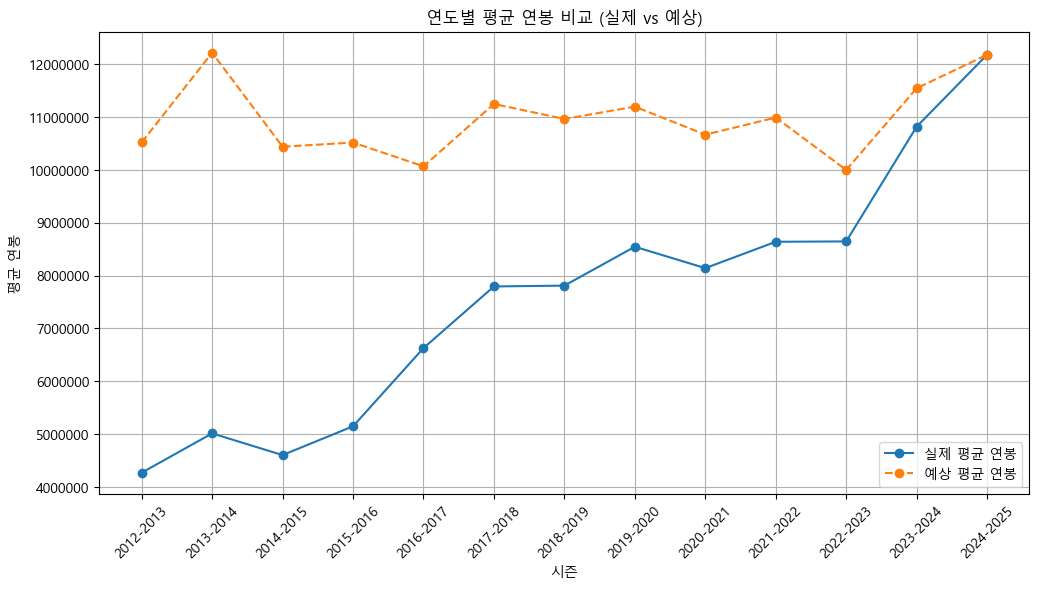

In [542]:
# 시즌별 실제 연봉과 예상 연봉 평균
yearly_avg_salary = final_data.groupby('SEASON')[['SALARY', 'ADJUSTED_SALARY_FOR_CAP']].mean()

plt.figure(figsize=(12, 6))
plt.plot(yearly_avg_salary.index, yearly_avg_salary['SALARY'], marker='o', label='실제 평균 연봉')
plt.plot(yearly_avg_salary.index, yearly_avg_salary['ADJUSTED_SALARY_FOR_CAP'], marker='o', linestyle='--', label='예상 평균 연봉')
plt.title("연도별 평균 연봉 비교 (실제 vs 예상)")
plt.xlabel("시즌")
plt.ylabel("평균 연봉")
plt.legend()
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### 상관관계 히트맵 시각화
- 예상 연봉(ASFC)와 경기당 평균 득점(PTS) 등이 높은 상관관계를 보인다.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


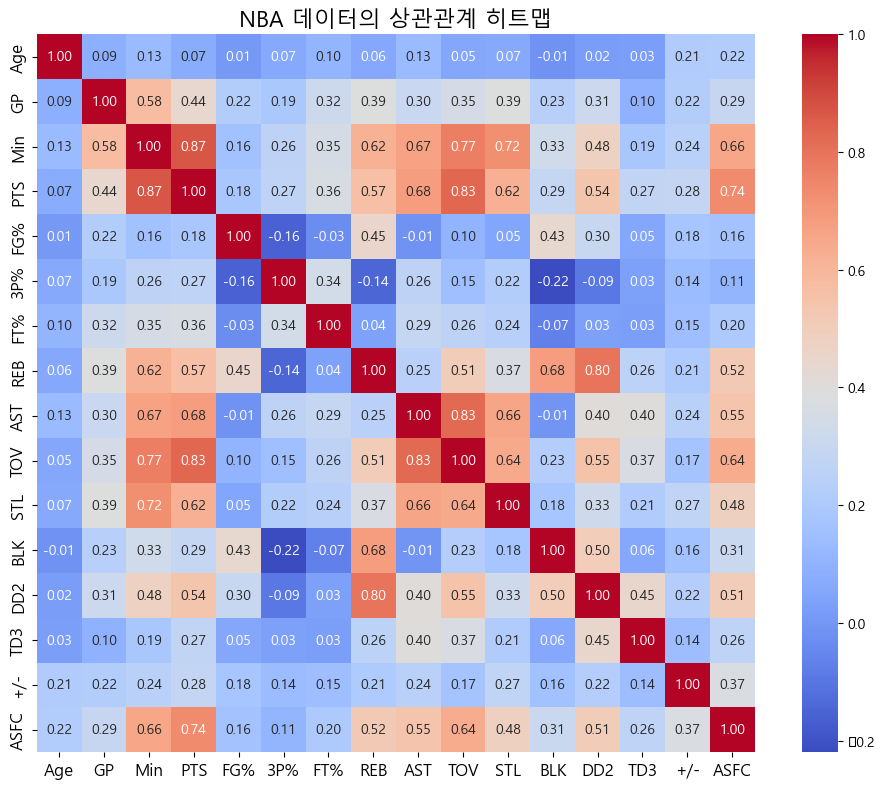

In [543]:
# 주요 연속형 변수 추출
correlation_data = final_data.iloc[:, 1:16]
correlation_data['ASFC'] = final_data[['ADJUSTED_SALARY_FOR_CAP']] # 너무 길어 약어로 변경
 
# 상관계수 계산
correlation_matrix = correlation_data.corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title("NBA 데이터의 상관관계 히트맵", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### 주요 변수의 분포를 확인하여 데이터 표준화 필요성을 판단

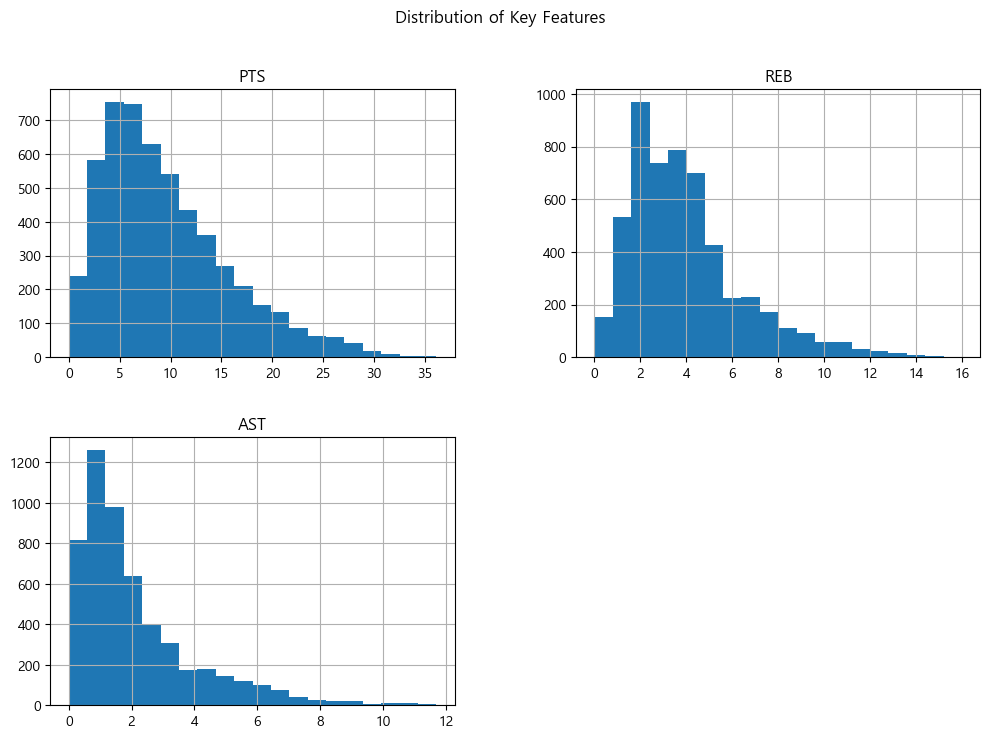

In [544]:
# 주요 변수 분포
final_data[['PTS', 'REB', 'AST']].hist(figsize=(12, 8), bins=20)
plt.suptitle('Distribution of Key Features')
plt.show()

### 조정된 연봉과 경기당 득점률 관계 시각화

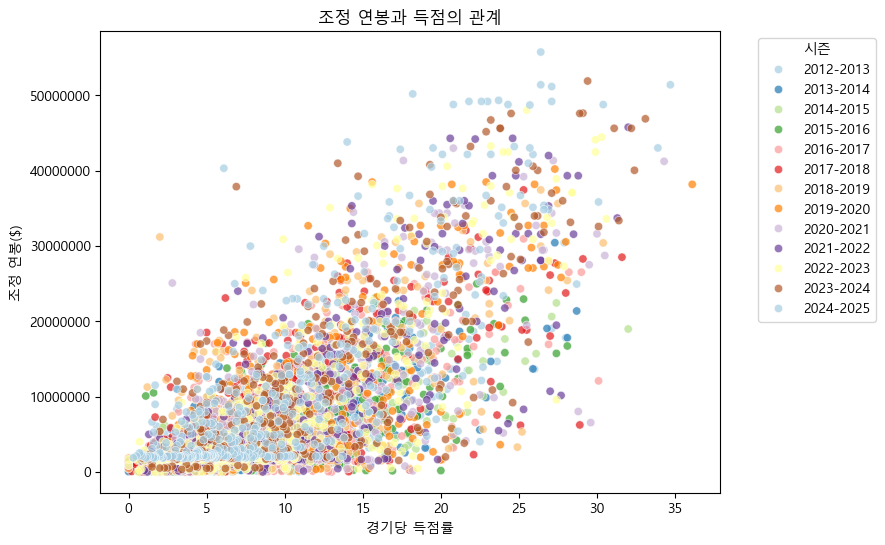

In [545]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_data, x='PTS', y='SALARY', hue='SEASON', palette='Paired', alpha=0.7)
plt.title(f"조정 연봉과 득점의 관계")
plt.xlabel('경기당 득점률')
plt.ylabel("조정 연봉($)")
plt.ticklabel_format(axis='y',useOffset=False, style='plain')     
plt.legend(title="시즌", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### 조정된 연봉과 효율 관계 시각화

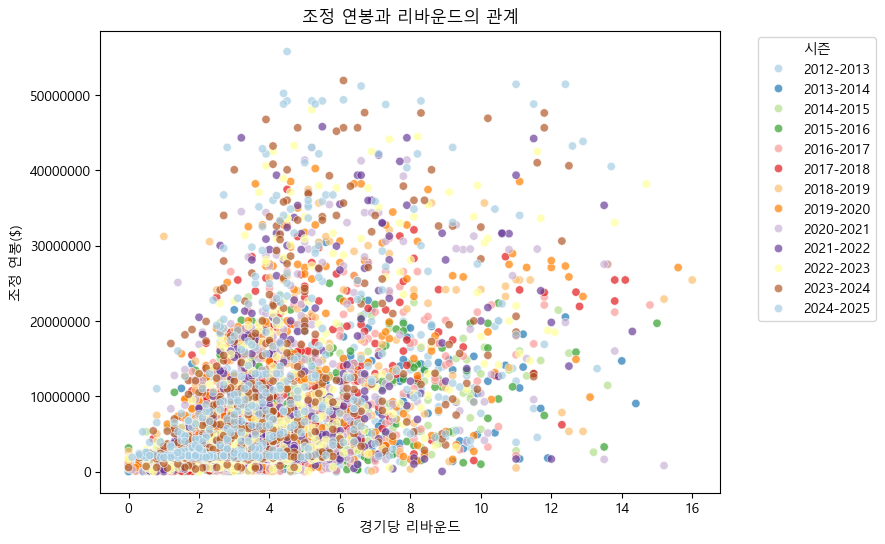

In [546]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_data, x='REB', y='SALARY', hue='SEASON', palette='Paired', alpha=0.7)
plt.title(f"조정 연봉과 리바운드의 관계")
plt.xlabel('경기당 리바운드')
plt.ylabel("조정 연봉($)")
plt.ticklabel_format(axis='y',useOffset=False, style='plain')     
plt.legend(title="시즌", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


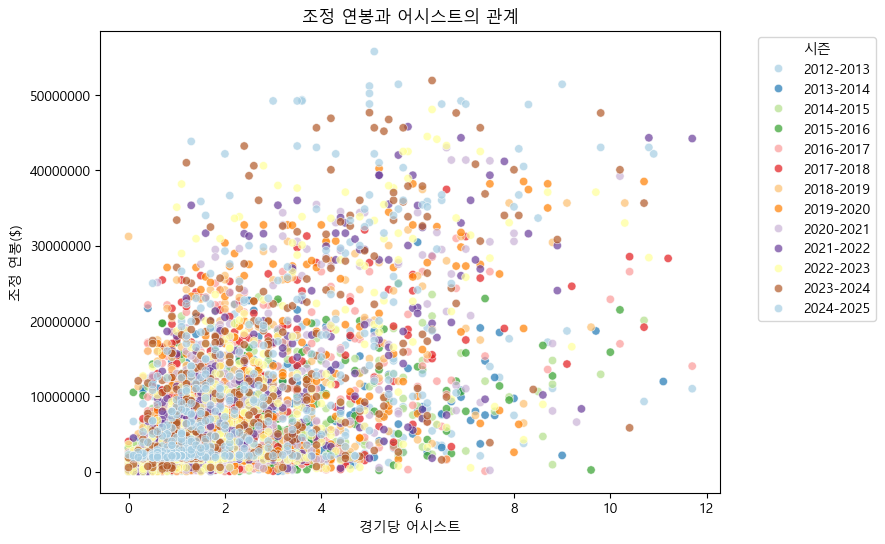

In [547]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_data, x='AST', y='SALARY', hue='SEASON', palette='Paired', alpha=0.7)
plt.title(f"조정 연봉과 어시스트의 관계")
plt.xlabel('경기당 어시스트')
plt.ylabel("조정 연봉($)")
plt.ticklabel_format(axis='y',useOffset=False, style='plain')     
plt.legend(title="시즌", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### 다양한 모델로 연봉 예측 학습

In [548]:
# 독립 변수
X = final_data.drop(columns=['Player', 'SEASON', 'SALARY', 'ADJUSTED_SALARY_FOR_CAP'])
print(X)

# 종속 변수
y = final_data[['ADJUSTED_SALARY_FOR_CAP']]

      Age  GP   Min   PTS   FG%   3P%    FT%   REB  AST  TOV  STL  BLK   DD2  \
0      23  66  38.6  28.0  49.6  38.7   86.0   8.0  3.5  3.8  1.3  1.2  18.0   
1      33  58  38.5  27.9  43.0  30.3   84.5   5.4  4.6  3.5  1.2  0.3   3.0   
2      27  62  37.5  27.1  53.1  36.2   77.1   7.9  6.2  3.4  1.9  0.8  23.0   
3      23  55  39.0  26.0  44.8  37.2   82.4  13.3  2.0  2.3  0.9  0.5  48.0   
4      23  66  35.3  23.6  45.7  31.6   82.3   4.6  5.5  3.6  1.7  0.3   7.0   
...   ...  ..   ...   ...   ...   ...    ...   ...  ...  ...  ...  ...   ...   
5332   26  17   2.7   0.8  35.3  20.0    0.0   0.3  0.3  0.2  0.0  0.1   0.0   
5333   27   8   4.7   0.8  20.0  28.6    0.0   0.3  0.0  0.3  0.0  0.3   0.0   
5334   22  25   3.0   0.7  50.0   0.0    0.0   0.5  0.2  0.2  0.2  0.0   0.0   
5335   23   8   2.9   0.5  16.7   0.0  100.0   0.6  0.1  0.3  0.3  0.3   0.0   
5336   21  34   3.0   0.3  19.0  11.1   66.7   0.1  0.2  0.3  0.1  0.0   0.0   

      TD3  +/-  
0     0.0  5.6  
1    

In [549]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from math import sqrt

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=42)),
    ('Random Forest Regressor', RandomForestRegressor(random_state=42, n_estimators=200, max_depth=10, min_samples_leaf=4, min_samples_split=2)),
    ('Support Vector Regressor', SVR(kernel='linear', C=1.0, epsilon=0.1)),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)),
    ('K-Nearest Neighbors Regressor', KNeighborsRegressor(n_neighbors=5)),
    ('XGBoost Regressor', XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1))
]

results = []
for name, model in models:
    model.fit(X_train_scaled, y_train.values.ravel())
    y_pred = model.predict(X_test_scaled)
    mse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((name, mse, r2))
    
    
results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'R2']).sort_values(by='MSE')
results_df

,Model,MSE,R2
2,Random Forest Regressor,6.234440e+06,0.711817
4,Gradient Boosting Regressor,6.317191e+06,0.704116
6,XGBoost Regressor,6.339770e+06,0.701997
5,K-Nearest Neighbors Regressor,6.830342e+06,0.654094
0,Linear Regression,7.013932e+06,0.635249
1,Decision Tree Regressor,8.747501e+06,0.432663
3,Support Vector Regressor,1.270266e+07,-0.196362


### 각 모델의 MSE와 R²를 시각화

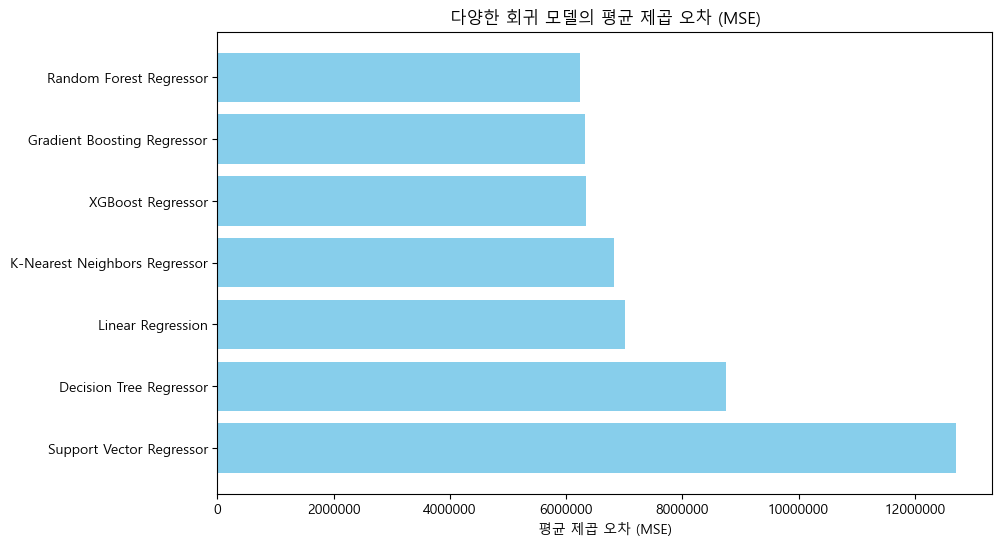

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


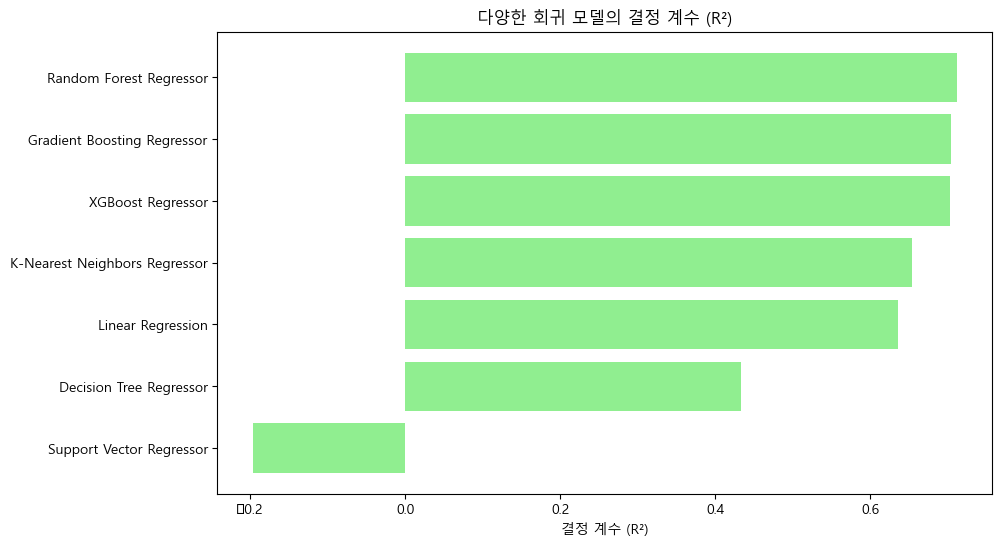

In [550]:
# MSE 그래프
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['MSE'], color='skyblue')
plt.xlabel('평균 제곱 오차 (MSE)')
plt.title('다양한 회귀 모델의 평균 제곱 오차 (MSE)')
plt.ticklabel_format(axis='x', useOffset=False, style='plain')
plt.gca().invert_yaxis()
plt.show()

# R² 그래프
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['R2'], color='lightgreen')
plt.xlabel('결정 계수 (R²)')
plt.title('다양한 회귀 모델의 결정 계수 (R²)')
plt.gca().invert_yaxis()
plt.show()


### 랜덤 포레스트를 이용해 특성 중요도 시각화

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


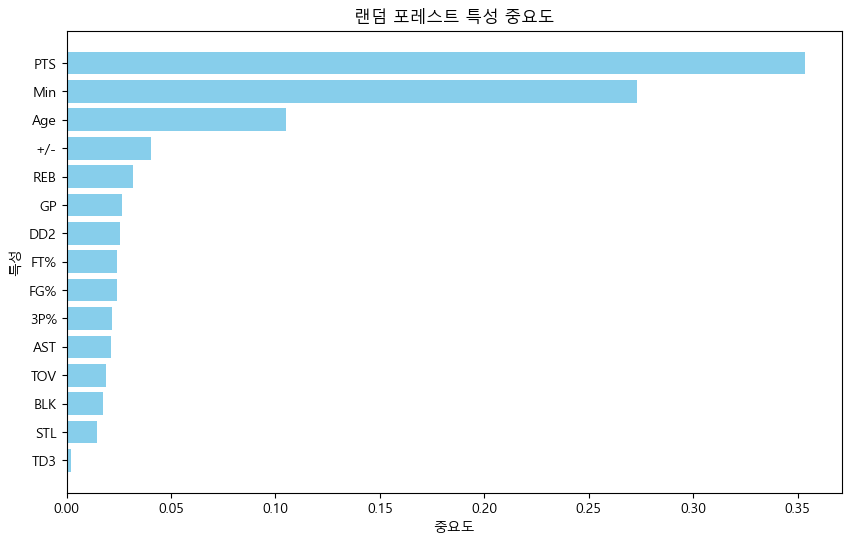

In [551]:
# 랜덤 포레스트 모델 학습
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)  # 이미 제공된 데이터로 학습

# 특성 중요도 추출
feature_importances = rf_model.feature_importances_
features = X.columns  # 특성 이름

# 데이터프레임으로 정렬
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('랜덤 포레스트 특성 중요도')
plt.xlabel('중요도')
plt.ylabel('특성')
plt.gca().invert_yaxis()  # 중요도가 높은 순서대로 보기 위해 축 반전
plt.show()

### 실제 연봉과 예측 연봉 비교 시각화

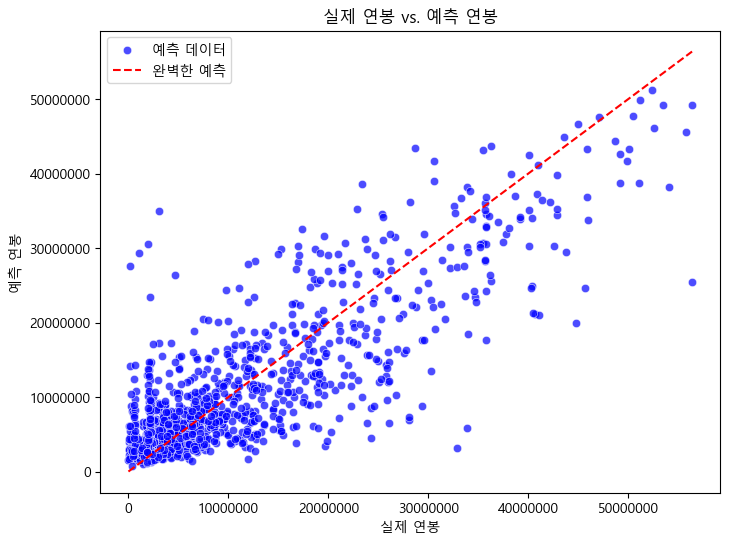

In [552]:
import matplotlib.pyplot as plt
import seaborn as sns

# 실제 값과 예측 값을 비교하기 위해 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Actual': y_test.values.ravel(),  # 실제 연봉 값
    'Predicted': y_pred  # 모델이 예측한 연봉 값
})

# 비교 시각화: 산점도
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=comparison_df['Actual'], 
    y=comparison_df['Predicted'], 
    alpha=0.7, 
    color='blue', 
    label='예측 데이터'
)
# 완벽한 예측을 나타내는 대각선 추가
plt.plot(
    [comparison_df['Actual'].min(), comparison_df['Actual'].max()],
    [comparison_df['Actual'].min(), comparison_df['Actual'].max()],
    'r--',
    label='완벽한 예측'
)
plt.title('실제 연봉 vs. 예측 연봉')  # 제목 추가
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.ticklabel_format(axis='x',useOffset=False, style='plain')
plt.xlabel('실제 연봉')  # x축 라벨
plt.ylabel('예측 연봉')  # y축 라벨
plt.legend()  # 범례 표시
plt.show()  # 그래프 출력